# 東京エレクトロン株価（日足）

In [1]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

symbol = '8035.T'
ticker = yf.Ticker(symbol)

df = ticker.history(period='6mo')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-28 00:00:00+09:00,35173.386719,35222.926700,34687.894902,35173.386719,2359300,0.0,0.0
2024-05-29 00:00:00+09:00,35569.708014,35599.432004,34945.504224,35054.492188,2285300,0.0,0.0
2024-05-30 00:00:00+09:00,34519.461744,34648.265705,33835.809947,34182.589844,3295500,0.0,0.0
2024-05-31 00:00:00+09:00,33637.649652,33776.361610,32924.273872,33320.593750,5360000,0.0,0.0
2024-06-03 00:00:00+09:00,33736.729860,34033.969771,33261.146003,33895.257812,2634200,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-22 00:00:00+09:00,22110.000000,22395.000000,22005.000000,22250.000000,3043700,0.0,0.0
2024-11-25 00:00:00+09:00,22575.000000,23320.000000,22565.000000,23135.000000,6050400,0.0,0.0
2024-11-26 00:00:00+09:00,23125.000000,23150.000000,22265.000000,22650.000000,4547900,0.0,0.0


## パラボリック SAR

In [2]:
def psar(ohlc: pd.DataFrame, iaf: float = 0.02, maxaf: float = 0.2) -> dict:
    length = len(ohlc)
    high = ohlc['High'].tolist()
    low = ohlc['Low'].tolist()
    close = ohlc['Close'].tolist()
 
    psar = close[0:len(close)]
    psarbull = [None] * length
    psarbear = [None] * length
 
    bull = True
    af = iaf
    ep = low[0]
    price_high = high[0]
    price_low = low[0]
 
    for i in range(2, length):
        if bull:
            psar[i] = psar[i - 1] + af * (price_high - psar[i - 1])
        else:
            psar[i] = psar[i - 1] + af * (price_low - psar[i - 1])
        reverse = False
 
        if bull:
            if low[i] < psar[i]:
                bull = False
                reverse = True
                psar[i] = price_high
                price_low = low[i]
                af = iaf
        else:
            if high[i] > psar[i]:
                bull = True
                reverse = True
                psar[i] = price_low
                price_high = high[i]
                af = iaf
 
        if not reverse:
            if bull:
                if high[i] > price_high:
                    price_high = high[i]
                    af = min(af + iaf, maxaf)
                if low[i - 1] < psar[i]:
                    psar[i] = low[i - 1]
                if low[i - 2] < psar[i]:
                    psar[i] = low[i - 2]
            else:
                if low[i] < price_low:
                    price_low = low[i]
                    af = min(af + iaf, maxaf)
                if high[i - 1] > psar[i]:
                    psar[i] = high[i - 1]
                if high[i - 2] > psar[i]:
                    psar[i] = high[i - 2]
 
        if bull:
            psarbull[i] = psar[i]
        else:
            psarbear[i] = psar[i]
 
    return {
        'bear': np.array(psarbear, dtype='float64'),
        'bull': np.array(psarbull, dtype='float64'),
    }

## 日足チャートとパラボリック SAR

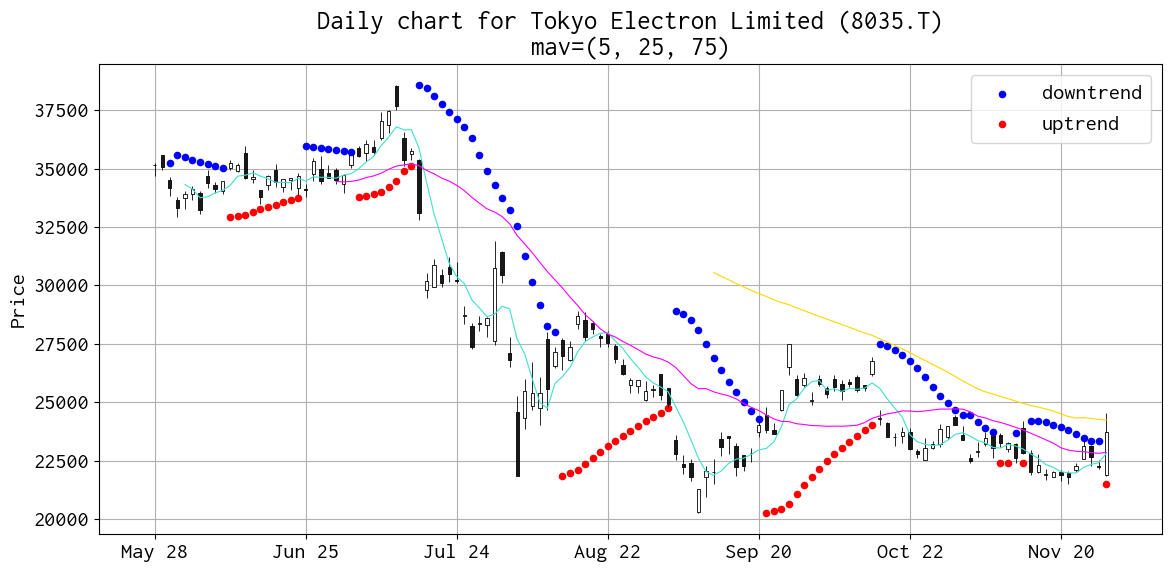

In [3]:
dict_psar = psar(df)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker.info['longName'], symbol))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol)

ax.grid()

plt.tight_layout()
plt.savefig('daily_chart_8035.png')
plt.show()

In [4]:
df.tail(2)['Close']

Date
2024-11-27 00:00:00+09:00    22240.0
2024-11-28 00:00:00+09:00    23740.0
Name: Close, dtype: float64

In [5]:
df.tail(2)['Close'].diff()

Date
2024-11-27 00:00:00+09:00       NaN
2024-11-28 00:00:00+09:00    1500.0
Name: Close, dtype: float64

## 東京エレクトロン（後場）

In [6]:
df2 = ticker.history(period='1d', interval='1m')
dt_noon = pd.to_datetime('%s 12:00:00+09:00' % str(df2.index[0].date()))
print(dt_noon)
df2[df2.index > dt_noon]

2024-11-28 12:00:00+09:00


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-11-28 12:30:00+09:00,23760.0,23820.0,23630.0,23640.0,6460000,0.0,0.0
2024-11-28 12:31:00+09:00,23655.0,23685.0,23540.0,23625.0,57300,0.0,0.0
2024-11-28 12:32:00+09:00,23625.0,23720.0,23625.0,23650.0,44900,0.0,0.0
2024-11-28 12:33:00+09:00,23665.0,23735.0,23650.0,23700.0,35700,0.0,0.0
2024-11-28 12:34:00+09:00,23700.0,23775.0,23685.0,23755.0,37200,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-28 15:20:00+09:00,23705.0,23720.0,23705.0,23715.0,14900,0.0,0.0
2024-11-28 15:21:00+09:00,23715.0,23735.0,23715.0,23725.0,16900,0.0,0.0
2024-11-28 15:22:00+09:00,23725.0,23735.0,23720.0,23730.0,11700,0.0,0.0


# Tokyo Electron Limited (ADR)

In [7]:
symbol1 = 'TOELY'
ticker1 = yf.Ticker(symbol1)

df1 = ticker1.history(period='6mo')
df1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-05-28 00:00:00-04:00,113.669998,114.870003,113.190002,114.400002,54500,0.0,0.0
2024-05-29 00:00:00-04:00,111.129997,111.660004,110.550003,111.070000,40500,0.0,0.0
2024-05-30 00:00:00-04:00,112.000000,112.000000,109.290001,109.599998,89200,0.0,0.0
2024-05-31 00:00:00-04:00,107.790001,108.070000,104.900002,106.160004,178900,0.0,0.0
2024-06-03 00:00:00-04:00,107.199997,109.919998,107.199997,109.300003,203100,0.0,0.0
...,...,...,...,...,...,...,...
2024-11-21 00:00:00-05:00,71.000000,73.290001,70.099998,71.099998,176600,0.0,0.0
2024-11-22 00:00:00-05:00,71.110001,74.199997,71.110001,72.089996,146200,0.0,0.0
2024-11-25 00:00:00-05:00,73.000000,77.169998,73.000000,74.739998,185100,0.0,0.0


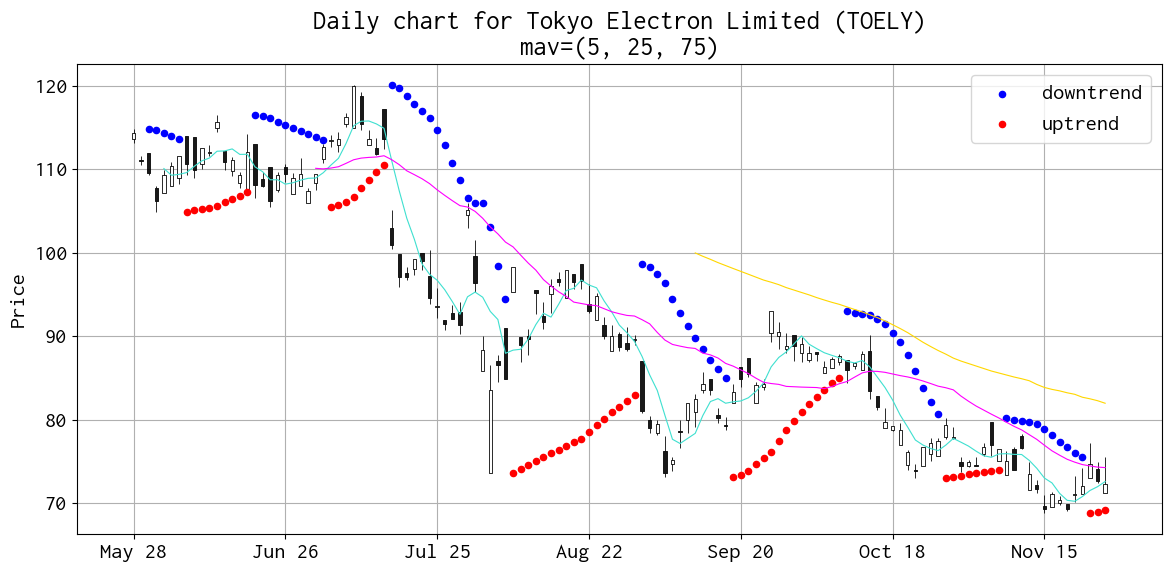

In [8]:
dict_psar = psar(df1)

FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)

apds  = [
    mpf.make_addplot(
        dict_psar['bear'],
        type='scatter',
        marker='o',
        markersize=20,
        color='blue',
        label='downtrend',
        ax=ax
    ),
    mpf.make_addplot(
        dict_psar['bull'],
        type='scatter',
        marker='o',
        markersize=20,
        color='red',
        label='uptrend',
        ax=ax
    ),
] 

mpf.plot(
    df1,
    type='candle',
    style='default',
    mav=(5, 25, 75),
    volume=False,
    addplot=apds,
    xrotation=0,
    ax=ax,
)
try:
    ax.set_title('Daily chart for %s (%s)\nmav=(5, 25, 75)' % (ticker1.info['longName'], symbol1))
except KeyError:
    ax.set_title('Daily chart for %s\nmav=(5, 25, 75)' % symbol1)

ax.grid()

plt.tight_layout()
plt.savefig('report_daily_chart_TOELY.png')
plt.show()